In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(42)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/var/folders/7q/vfb4br_x0vnc613rxty89lnh0000gn/T/ipykernel_19094/548287556.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# BVP PARENT CLASS
class BVP:
    def __init__(self, extremes, boundary_conditions):
        self.extremes = extremes  # Tuple (start, end) of the domain
        self.boundary_conditions = boundary_conditions  # Tuple (BC at start, BC at end)

# Define child class
# 2ND ORDER LINEAR CONSTANT COEFFICIENTS, AUTONOMOUS, DIRICHLET BCs
class BVP_lcc_homog(BVP):
    def __init__(self, extremes, boundary_conditions, coefficients, analytical_solution):
        super().__init__(extremes, boundary_conditions)  # Initialize parent class attributes
        self.coefficients = coefficients  # Tuple (alpha1, alpha0) for y'' + alpha1*y' + alpha0*y = 0
        self.analytical_solution = analytical_solution  # FUNCTION which returns the analytical solution

    def get_analytical_solution(self, x):
        return self.analytical_solution(x)  # Assuming analytical_solution is a function of x

In [3]:
# Create an instance of BVP_lcc
# get some oscillations in here
# DO NOT CHANGE THIS

def exact_sol(x):
    A = 1
    B = - np.exp(3 * np.pi) * np.exp(-3 * np.pi)
    return np.exp(-2 * x) * (A * np.cos(5 * x) + B * np.sin(5 * x))


# DO NOT CHANGE THIS
bvp = BVP_lcc_homog((0,3 * np.pi / 2), (1,np.exp(-3 * np.pi)), (4,29), exact_sol)


# ANOTHER BVP:
# y'' = 9 * y, y(0) = 0, y(1) = 6

"""
def exact_sol(x):
    return (6 * np.exp(3 - 3 * x) * (-1 + np.exp(6 * x)))/ (-1 + np.exp(6))

bvp = BVP_lcc_homog((0,1),(0,6),(0,-9), exact_sol)
"""


'\ndef exact_sol(x):\n    return (6 * np.exp(3 - 3 * x) * (-1 + np.exp(6 * x)))/ (-1 + np.exp(6))\n\nbvp = BVP_lcc_homog((0,1),(0,6),(0,-9), exact_sol)\n'

In [29]:
# Training loop
def train_model(bvp: BVP_lcc_homog, model, no_train_points, no_epochs, learn_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    #print(bvp.extremes[1], bvp.boundary_conditions[1])

    for epoch in range(no_epochs):
        optimizer.zero_grad()
        
        # Sample x within the domain
        #x = torch.cat((torch.linspace(0,1.5,2000), torch.linspace(1.5, bvp.extremes[1], 1000), torch.linspace(2, bvp.extremes[1], 500)), dim=0).unsqueeze(1)
        x = torch.linspace(bvp.extremes[0], bvp.extremes[1], no_train_points).unsqueeze(1)  # Unsqueeze to make it a column vector

        x.requires_grad_(True)  # Enable gradient computation for x
        
        # Compute y and its derivatives
        y = model(x)
        y.requires_grad_(True)
        y_prime = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        y_double_prime = torch.autograd.grad(y_prime, x, torch.ones_like(y_prime), create_graph=True)[0]
        
        # Compute the loss
        loss_ode = torch.mean((y_double_prime + bvp.coefficients[0] * y_prime + bvp.coefficients[1] * y)**2)
        
        loss_bc = (model(torch.tensor([[bvp.extremes[0]]], dtype=torch.float32)) - bvp.boundary_conditions[0])**2 + (model(torch.tensor([[bvp.extremes[1]]], dtype=torch.float32)) - bvp.boundary_conditions[1])**2
        loss = loss_ode + loss_bc
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [36]:
# TRAIN

# parameters below seemed to work well
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 1)
)

train_model(bvp, model, 30, 10000, 0.05)

"""
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 1)
)

train_model(bvp, model, 30, 20000, 0.005)
"""

Epoch 0, Loss: 32.56364822387695
Epoch 1000, Loss: 0.940144956111908
Epoch 2000, Loss: 0.6730420589447021
Epoch 3000, Loss: 0.16041156649589539
Epoch 4000, Loss: 0.10729792714118958
Epoch 5000, Loss: 0.10064425319433212
Epoch 6000, Loss: 0.0787525400519371
Epoch 7000, Loss: 0.0508178249001503
Epoch 8000, Loss: 0.04456734284758568
Epoch 9000, Loss: 0.027730176225304604


'\nmodel = torch.nn.Sequential(\n    torch.nn.Linear(1, 10),\n    torch.nn.Tanh(),\n    torch.nn.Linear(10, 1)\n)\n\ntrain_model(bvp, model, 30, 20000, 0.005)\n'

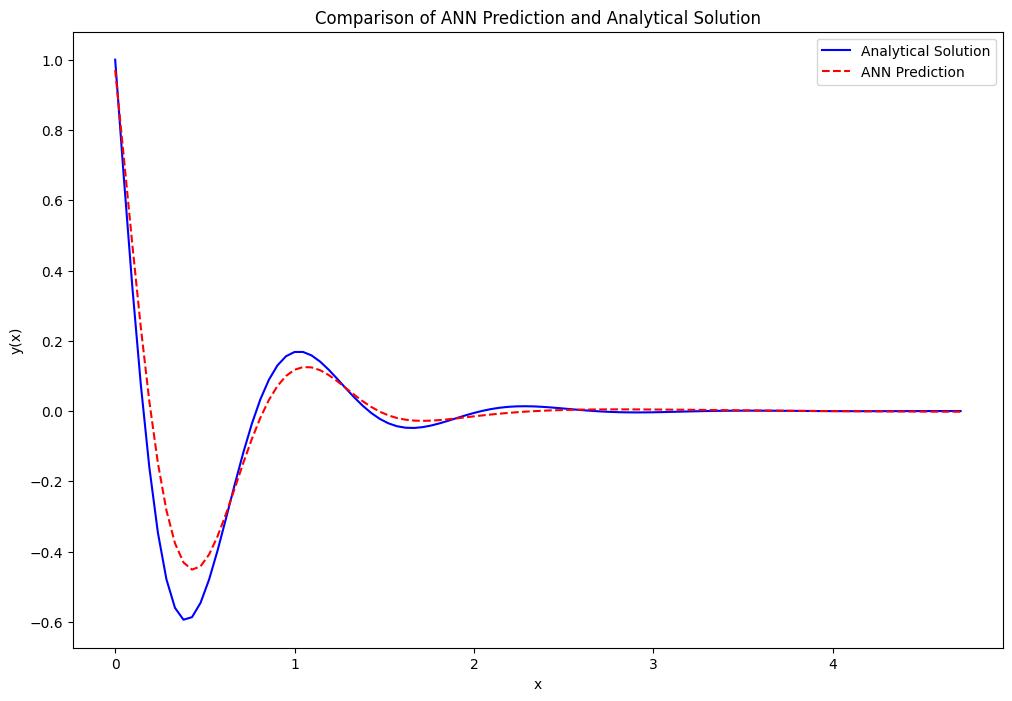

In [37]:
# Sampling x values
x_values = np.linspace(bvp.extremes[0], bvp.extremes[1], 100)
x_tensor = torch.tensor(x_values.reshape(-1, 1), dtype=torch.float32)

# Use the trained model for predictions (make sure it's already loaded and trained)
with torch.no_grad():  # No need for gradients here
    y_pred = model(x_tensor).numpy()

# Compute the analytical solution
y_true = exact_sol(x_values)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_values, y_true, label='Analytical Solution', color='blue')
plt.plot(x_values, y_pred, label='ANN Prediction', linestyle='--', color='red')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Comparison of ANN Prediction and Analytical Solution')
plt.legend()
plt.show()
